## Intro to NLP (Natural Language Processing):  Week 5 - NLP in Action (Supervised Text Classification)

Dataset Link: https://www.kaggle.com/c/fake-news/data

Dataset Name: train.csv, test.csv

Dataset Description: Build a system to identify unreliable news articles, using 3 files:
- train.csv: A full training dataset with the following attributes:
  - id: unique id for a news article
  - title: the title of a news article
  - author: author of the news article
  - text: the text of the article; could be incomplete
  - label: a label that marks the article as potentially unreliable
    - 1: unreliable
    - 0: reliable

- test.csv: A testing training dataset with all the same attributes at train.csv without the label

**Steps to access, download, and use the dataset:**



1.   Access the above link to kaggle, click on "Data" tab and download "train.csv", "test.csv", and submit.csv.
2.   Once downloaded, click on the files to unzip them. 
3.   Save the file in a folder easily accessible - E.g. "Documents"
4.   Open a Google Colab Notebook
5.   In the left pane of the Google Colab, click on "Files" and select the upload icon (Icon hover text: "Upload to session storage")
6.   You are ready to start using the data in the Colab Notebook.



Data location within Colab: '/content/train.csv', '/content/test.csv'

Check whick folder in the Google Colab notebook we are currently in?

In [1]:
pwd

'/content'

Now that we know which folder we are in, how do we see if the data we loaded (in step 5 above) is correctly loaded or not?

In [2]:
ls

sample_data/  test.csv  train.csv


## Load dataset + describe data

In [286]:
from time import time
import pandas as pd
import numpy as np
import re
import sys
import csv
csv.field_size_limit(sys.maxsize)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import itertools
import datetime

import pprint
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [292]:
train = pd.read_csv('/content/train.csv', header=0, lineterminator='\n')
train = train.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set')

# Removing empty rows from csv 
train.dropna(axis=0, how='all',inplace=True)
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty rows')

train.head()

There are 20800 rows and 5 columns in the training set
There are 20800 rows and 5 columns in the training set after removing empty rows


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [293]:
test = pd.read_csv('/content/test.csv', header=0, lineterminator='\n')
test = test.applymap(lambda x: x.strip() if isinstance(x, str) else x)

nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set')

# Removing empty rows from csv 
test.dropna(axis=0, how='all',inplace=True)
nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set after removing empty rows')

test.head()

There are 5200 rows and 4 columns in the testing set
There are 5200 rows and 4 columns in the testing set after removing empty rows


,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [294]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 975.0+ KB


In [295]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 203.1+ KB


In [296]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [297]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [298]:
train = train[train['text'].notna()]

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing empty "text" columns')

train.head()


There are 20761 rows and 5 columns in the training set after removing empty "text" columns


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [299]:
train.isnull().sum()

id           0
title      558
author    1918
text         0
label        0
dtype: int64

In [300]:
test = test[test['text'].notna()]

nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the testing set after removing empty "text" columns')

test.head()

There are 5193 rows and 4 columns in the testing set after removing empty "text" columns


,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [301]:
train.isnull().sum()

id           0
title      558
author    1918
text         0
label        0
dtype: int64

In [302]:
test.isnull().sum()

id          0
title     122
author    496
text        0
dtype: int64

In [303]:
# even though it's not crucial but we want to keep the data for title and author in the training set, so update nan values as ' '

train=train.fillna(' ')
test=test.fillna(' ')

In [304]:
train.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [305]:
test.isnull().sum()

id        0
title     0
author    0
text      0
dtype: int64

## Pre-Processing Steps:
These are the same from previous sessions: 
  - Expand contractions
  - Noise cleaning
  - Remove *stopwords*

In [254]:
# Contraction Mapping

!pip install contractions
import contractions

#### Expand Contractions

In [306]:
#while doing the contraction mapping, the team found out that we had a edge-case, where the word below, because how it had some special characters, failed! so, this step is taking out all the rows that contains that word

train = train[~train['text'].str.contains("İletişim")]

nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns in the training set after removing edge-case word "İletişim"')

train.head()


There are 20755 rows and 5 columns in the training set after removing edge-case word "İletişim"


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [307]:
test = test[~test['text'].str.contains("İletişim")]

nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns in the test set after removing edge-case word "İletişim"')

test.head()

There are 5190 rows and 4 columns in the test set after removing edge-case word "İletişim"


,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [308]:
train['total']=train['title']+' '+train['author']+train['text']
test['total']=test['title']+' '+test['author']+test['text']

print("Done - Combined column title, author, and text in one column for training data to have more content")

Done - Combined column title, author, and text in one column for training data to have more content


In [309]:
train['total'] = train['total'].apply(lambda x: [contractions.fix(word) for word in x.split(' ')])
train.drop(["title","author","text"], axis=1, inplace = True)

test['total'] = test['total'].apply(lambda x: [contractions.fix(word) for word in x.split(' ')])
test.drop(["title","author","text"], axis=1, inplace = True)

In [ ]:
# for i in test['total']:
#   word = i.split(' ')
#   for j in word:
#     print(j)
#     contractions.fix(j) 

In [310]:
train.head()

,id,label,total
0,0,1,"[House, Dem, Aide:, We, did not, Even, See, Co..."
1,1,0,"[FLYNN:, Hillary, Clinton,, Big, Woman, on, Ca..."
2,2,1,"[Why, the, Truth, Might, Get, You, Fired, Cons..."
3,3,1,"[15, Civilians, Killed, In, Single, US, Airstr..."
4,4,1,"[Iranian, woman, jailed, for, fictional, unpub..."


In [311]:
test.head()

,id,total
0,20800,"[Specter, of, Trump, Loosens, Tongues,, if, No..."
1,20801,"[Russian, warships, ready, to, strike, terrori..."
2,20802,"[#NoDAPL:, Native, American, Leaders, Vow, to,..."
3,20803,"[Tim, Tebow, Will, Attempt, Another, Comeback,..."
4,20804,"[Keiser, Report:, Meme, Wars, (E995), Truth, B..."


In [312]:
#joining back the list of items into one string
train['total'] = [' '.join(map(str, l)) for l in train['total']]
test['total'] = [' '.join(map(str, l)) for l in test['total']]

train.head()

,id,label,total
0,0,1,House Dem Aide: We did not Even See Comey’s Le...
1,1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,1,Why the Truth Might Get You Fired Consortiumne...
3,3,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,1,Iranian woman jailed for fictional unpublished...


In [313]:
test.head()

,id,total
0,20800,"Specter of Trump Loosens Tongues, if Not Purse..."
1,20801,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ..."
4,20804,Keiser Report: Meme Wars (E995) Truth Broadcas...


#### Noise Cleaning

In [314]:
# Noise Cleaning - spacing, special characters, lowercasing 
import regex as re

train['total'] = train['total'].str.lower()
train['total'] = train['total'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

train.head()

,id,label,total
0,0,1,house dem aide we did not even see comeys lett...
1,1,0,flynn hillary clinton big woman on campus bre...
2,2,1,why the truth might get you fired consortiumne...
3,3,1,15 civilians killed in single us airstrike hav...
4,4,1,iranian woman jailed for fictional unpublished...


In [315]:
test['total'] = test['total'].str.lower()
test['total'] = test['total'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

test.head()

,id,total
0,20800,specter of trump loosens tongues if not purse ...
1,20801,russian warships ready to strike terrorists ne...
2,20802,nodapl native american leaders vow to stay all...
3,20803,tim tebow will attempt another comeback this t...
4,20804,keiser report meme wars e995 truth broadcast n...


Regex explanation: 

1.   [^] matches everything but everything inside the blockquotes
2.   \w matches any word character (equal to [a-zA-Z0-9_])
3.   \d matches a digit (equal to [0-9])
4.   \s matches any whitespace character (equal to [\r\n\t\f\v ])
5.   \' matches the character ' literally (case sensitive)
6.   '+' matches between one and unlimited times, as many times as possible, giving back as needed

In [316]:
#nltk tokenization

train['total_tokenize'] = train['total'].apply(word_tokenize)
test['total_tokenize'] = test['total'].apply(word_tokenize)

train.head()

,id,label,total,total_tokenize
0,0,1,house dem aide we did not even see comeys lett...,"[house, dem, aide, we, did, not, even, see, co..."
1,1,0,flynn hillary clinton big woman on campus bre...,"[flynn, hillary, clinton, big, woman, on, camp..."
2,2,1,why the truth might get you fired consortiumne...,"[why, the, truth, might, get, you, fired, cons..."
3,3,1,15 civilians killed in single us airstrike hav...,"[15, civilians, killed, in, single, us, airstr..."
4,4,1,iranian woman jailed for fictional unpublished...,"[iranian, woman, jailed, for, fictional, unpub..."


In [317]:
test.head()

,id,total,total_tokenize
0,20800,specter of trump loosens tongues if not purse ...,"[specter, of, trump, loosens, tongues, if, not..."
1,20801,russian warships ready to strike terrorists ne...,"[russian, warships, ready, to, strike, terrori..."
2,20802,nodapl native american leaders vow to stay all...,"[nodapl, native, american, leaders, vow, to, s..."
3,20803,tim tebow will attempt another comeback this t...,"[tim, tebow, will, attempt, another, comeback,..."
4,20804,keiser report meme wars e995 truth broadcast n...,"[keiser, report, meme, wars, e995, truth, broa..."


In [268]:
# initializing Stop words libraries

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Visualizations

In [269]:
# Before removing checking occurances of stopwords in article content

%matplotlib inline
from matplotlib import pyplot as plt

def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    x,y=zip(*top)
    plt.figure(figsize=(10,10))
    plt.bar(x,y)

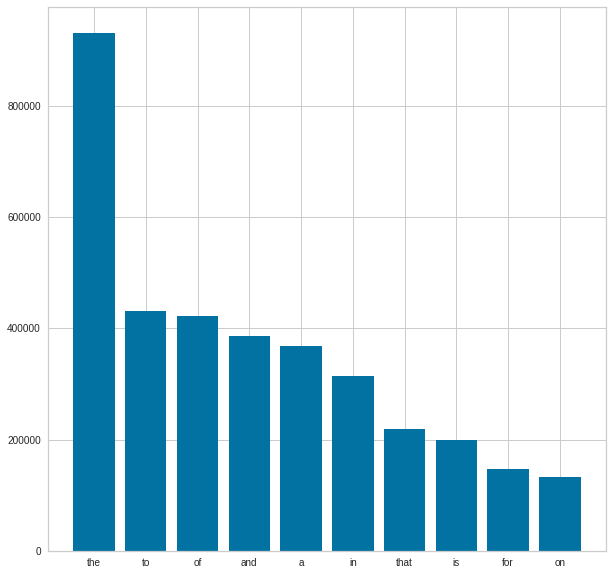

In [270]:
plot_top_stopwords_barchart(train['total'])

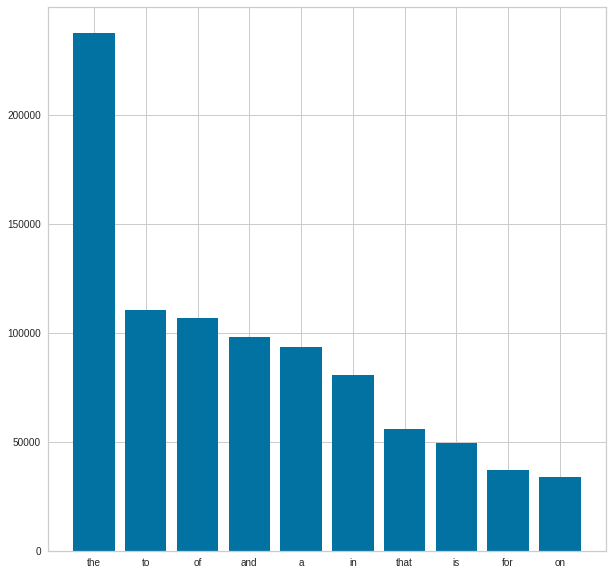

In [271]:
plot_top_stopwords_barchart(test['total'])

In [272]:
import seaborn as sns
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:50]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)


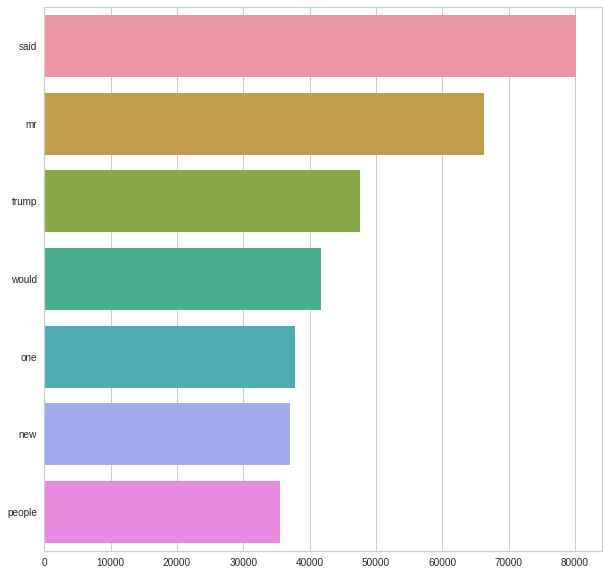

In [273]:
plot_top_non_stopwords_barchart(train['total'])

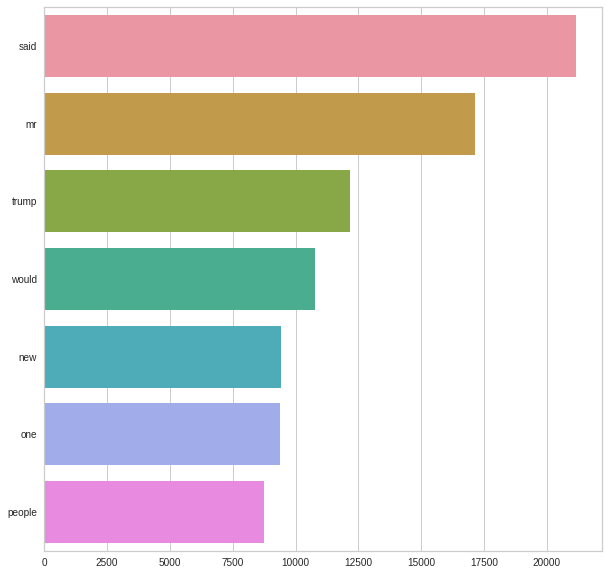

In [274]:
plot_top_non_stopwords_barchart(test['total'])

#### Remove stopwords

In [318]:
# Now we remove stopwords 

train['total_tokenize'] = train['total_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
train['total_tokenize_join'] = [' '.join(map(str, l)) for l in train['total_tokenize']]

train.head()

,id,label,total,total_tokenize,total_tokenize_join
0,0,1,house dem aide we did not even see comeys lett...,"[house, dem, aide, even, see, comeys, letter, ...",house dem aide even see comeys letter jason ch...
1,1,0,flynn hillary clinton big woman on campus bre...,"[flynn, hillary, clinton, big, woman, campus, ...",flynn hillary clinton big woman campus breitba...
2,2,1,why the truth might get you fired consortiumne...,"[truth, might, get, fired, consortiumnewscomwh...",truth might get fired consortiumnewscomwhy tru...
3,3,1,15 civilians killed in single us airstrike hav...,"[15, civilians, killed, single, us, airstrike,...",15 civilians killed single us airstrike identi...
4,4,1,iranian woman jailed for fictional unpublished...,"[iranian, woman, jailed, fictional, unpublishe...",iranian woman jailed fictional unpublished sto...


In [319]:
test['total_tokenize'] = test['total_tokenize'].apply(lambda x: [word for word in x if word not in stop_words])
test['total_tokenize_join'] = [' '.join(map(str, l)) for l in test['total_tokenize']]

test.head()

,id,total,total_tokenize,total_tokenize_join
0,20800,specter of trump loosens tongues if not purse ...,"[specter, trump, loosens, tongues, purse, stri...",specter trump loosens tongues purse strings si...
1,20801,russian warships ready to strike terrorists ne...,"[russian, warships, ready, strike, terrorists,...",russian warships ready strike terrorists near ...
2,20802,nodapl native american leaders vow to stay all...,"[nodapl, native, american, leaders, vow, stay,...",nodapl native american leaders vow stay winter...
3,20803,tim tebow will attempt another comeback this t...,"[tim, tebow, attempt, another, comeback, time,...",tim tebow attempt another comeback time baseba...
4,20804,keiser report meme wars e995 truth broadcast n...,"[keiser, report, meme, wars, e995, truth, broa...",keiser report meme wars e995 truth broadcast n...


In [277]:
# Let's evaluate the POS tags for our train set data
tagged_stanzas_train = []
tagged_train = []

for word in train['total_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_train.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_train.append(tagged_stanzas_train)

In [278]:
# Let's evaluate the POS tags for our test set data
tagged_stanzas_test = []
tagged_test = []

for word in test['total_tokenize']:
  tagged_word = nltk.pos_tag(word)
  tagged_stanzas_test.append(tagged_word)

# This format is needed for below visualizer as in takes only two values. If you skip this format, it might give you - "too many values to unpack error" 
tagged_test.append(tagged_stanzas_test)

#### Yellow Brick: POS Visualizer

In [202]:
# Yellow Brick is a POS visualizer - https://github.com/DistrictDataLabs/yellowbrick/blob/master/docs/api/text/postag.rst
# You may need to reload the workbook to activate it. In that case, re-run all cells again from the beginning 

!pip install -U yellowbrick

     |████████████████████████████████| 266kB 4.8MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


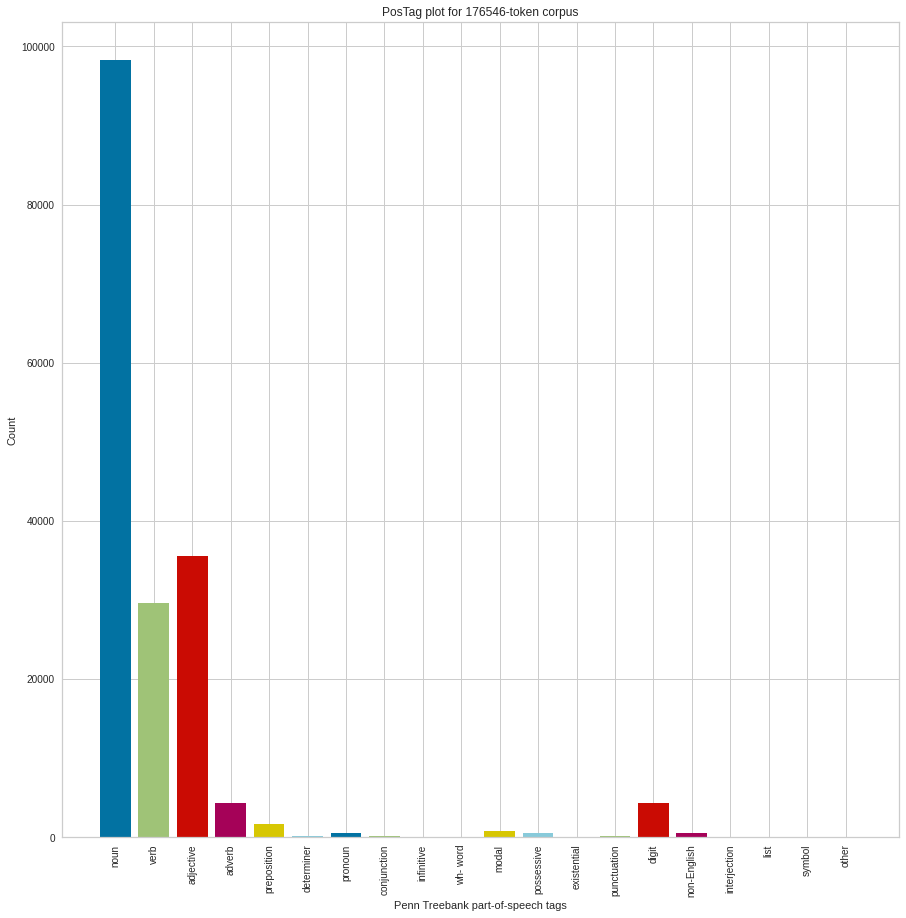

In [203]:
# Create the visualizer for train test

from yellowbrick.text import PosTagVisualizer
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_train)
viz.show()

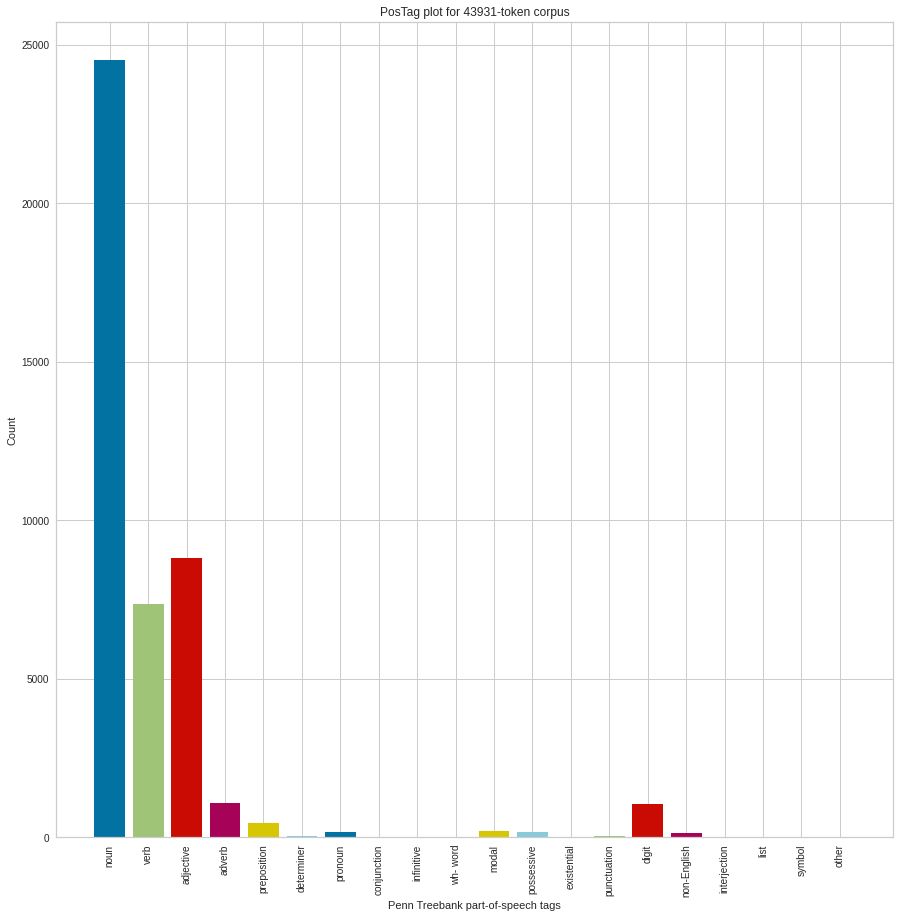

In [205]:
# Create the visualizer for test test

from yellowbrick.text import PosTagVisualizer
plt.figure(figsize=(15,15))
viz = PosTagVisualizer()
viz.fit(tagged_test)
viz.show()

Some examples of POS Tags (via Universal Tagger)

Refer: http://www.nltk.org/book/ch05.html

![tagset](https://camo.githubusercontent.com/515359c32d2839f79bc166c07ff96fb70a0f82e5/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f3730302f312a62444d64712d457061417232664c544e38344c6a67672e706e67)



## Text Classification Methodology

In [320]:
# Now let's check if number of examples for fake vs not-fake label is equal or not. Seems like in this case it's very balanced. 

train["label"].value_counts()


0    10387
1    10368
Name: label, dtype: int64

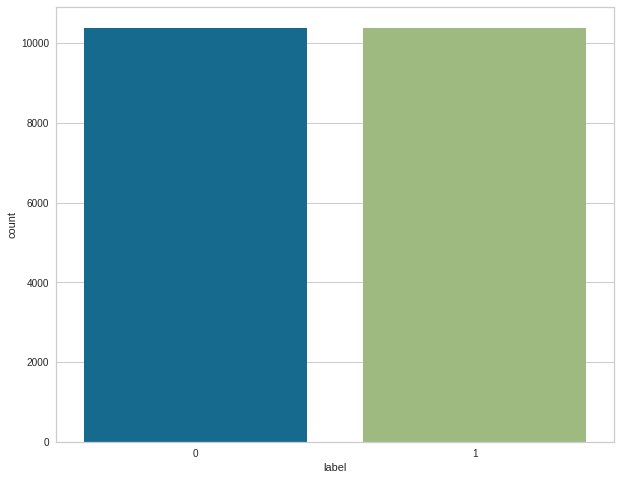

In [321]:
# we see there is an equal number of distribution of target features

rcParams["figure.figsize"] = 10,8
sns.countplot(x = train["label"])

In [322]:
# lets extract the label column from train dataframe to be the target 'y' variable
targets = train['label'].values

# Drop the 'label' column from train dataset
train.drop("label", axis=1, inplace = True)
train.head()

,id,total,total_tokenize,total_tokenize_join
0,0,house dem aide we did not even see comeys lett...,"[house, dem, aide, even, see, comeys, letter, ...",house dem aide even see comeys letter jason ch...
1,1,flynn hillary clinton big woman on campus bre...,"[flynn, hillary, clinton, big, woman, campus, ...",flynn hillary clinton big woman campus breitba...
2,2,why the truth might get you fired consortiumne...,"[truth, might, get, fired, consortiumnewscomwh...",truth might get fired consortiumnewscomwhy tru...
3,3,15 civilians killed in single us airstrike hav...,"[15, civilians, killed, single, us, airstrike,...",15 civilians killed single us airstrike identi...
4,4,iranian woman jailed for fictional unpublished...,"[iranian, woman, jailed, fictional, unpublishe...",iranian woman jailed fictional unpublished sto...


#### Refer sklearn documentation for tfidf and count vectorizer here:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

Refresh:
Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

The formula that is used to compute the tf-idf for a term t of a document d in a document set is tf-idf(t, d) = tf(t, d) * idf(t), and the idf is computed as:
**idf(t) = log [ n / df(t) ] + 1 (if smooth_idf=False)**

where n is the total number of documents in the document set and df(t) is the document frequency of t; the document frequency is the number of documents in the document set that contain the term t. The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored. (Note that the idf formula above differs from the standard textbook notation that defines the idf as:
**idf(t) = log [ n / (df(t) + 1) ] (if smooth_idf=True))**.

![alt text](https://miro.medium.com/max/1200/1*V9ac4hLVyms79jl65Ym_Bw.jpeg)

In [282]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

Example: What kind of ngrams does range(1,2) create?

```
sentence = ["an apple a day keeps the doctor away"]
v=text.CountVectorizer(ngramrange=(1,2))

print(v.fit(sentence).vocabulary)

Result:
{'an': 0, 'apple': 2, 'day': 5, 'keeps': 9, 'the': 11, 'doctor': 7, 'away': 4, 'an apple': 1, 'apple day': 3, 'day keeps': 6, 'keeps the': 10, 'the doctor': 12, 'doctor away': 8}
```



In [283]:
# fit train data to the count vectorizer
train_counts = count_vectorizer.fit_transform(train['total'].values)

#fit the ngrams count to the tfidf transformers
train_tfidf = transformer.fit_transform(train_counts)


###Refer sklearn documentation for train-test split here:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [284]:
from sklearn.model_selection import train_test_split

#  If train-test size is not initialized, test_size will be set to 0.25 and train_set = 1-test_size

X_train, X_test, y_train, y_test = train_test_split(train_tfidf, targets, random_state=0)

In [285]:
Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)

print('Accuracy of ExtraTrees classifier on train set: {:.2f}'.format(Extr.score(X_train, y_train)))

print('Accuracy of ExtraTrees classifier on test set: {:.2f}'.format(Extr.score(X_test, y_test)))

Accuracy of ExtraTrees classifier on train set: 1.00
Accuracy of ExtraTrees classifier on test set: 0.84


In [287]:
Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)

print('Accuracy of Adaboost classifier on training set: {:.2f}'.format(Adab.score(X_train, y_train)))

print('Accuracy of Adaboost classifier on test set: {:.2f}'.format(Adab.score(X_test, y_test)))


Accuracy of Adaboost classifier on training set: 0.97
Accuracy of Adaboost classifier on test set: 0.96


In [288]:
RandomFC= RandomForestClassifier(n_estimators=5)
RandomFC.fit(X_train, y_train)

print('Accuracy of randomforest classifier on training set: {:.2f}'.format(RandomFC.score(X_train, y_train)))

print('Accuracy of randomforest classifier on test set: {:.2f}'.format(RandomFC.score(X_test, y_test)))



Accuracy of randomforest classifier on training set: 0.98
Accuracy of randomforest classifier on test set: 0.81


In [289]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)

print('Accuracy of NB  classifier on training set: {:.2f}'.format(NB.score(X_train, y_train)))

print('Accuracy of NB classifier on test set: {:.2f}'.format(NB.score(X_test, y_test)))


Accuracy of NB  classifier on training set: 0.86
Accuracy of NB classifier on test set: 0.75


In [325]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

print('Accuracy of Logreg classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))

print('Accuracy of Logreg classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))



Accuracy of Logreg classifier on training set: 1.00
Accuracy of Logreg classifier on test set: 0.98


**Measuring Model Performance**

While there are other ways of measuring model performance (precision, recall, F1 Score, ROC Curve, etc), we are going to keep this simple and use accuracy as our metric.

**Accuracy** is defined as:

`fraction of correct predictions: correct predictions / total number of data points`

In [326]:
# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print(score)

0.9764887261514743


In [340]:
# Predict and calculate accuracy
from sklearn.metrics import accuracy_score

predictions = logreg.predict(X_test)
score=accuracy_score(y_test,predictions)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 97.65%


**Confusion Matrix**

A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known. In this section, I am just showing two python packages (Seaborn and Matplotlib) for making confusion matrices more understandable and visually appealing.

The confusion matrix below is not visually super informative or visually appealing.

In [345]:
from sklearn import metrics

CM = metrics.confusion_matrix(y_test, predictions)
print(CM)

[[2530   77]
 [  45 2537]]


Method 1 (Seaborn)
As you can see below, this method produces a more understandable and visually readable confusion matrix using seaborn.


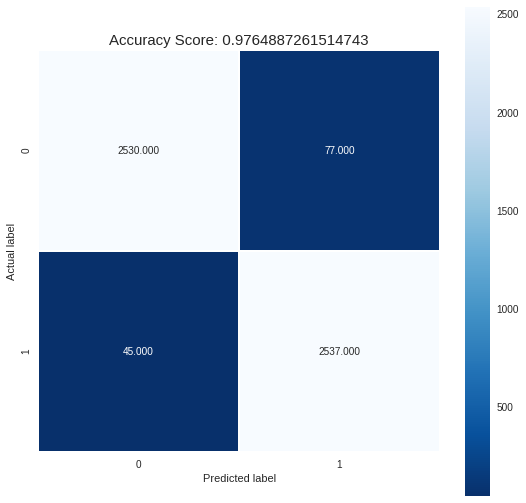

In [342]:
plt.figure(figsize=(9,9))
sns.heatmap(CM, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### From the confusion matrix we can make the following conclusions:


1. Our model successfully predicted 2530 positives
2. Our model successfully predicted 2527 negatives.
3. Our model predicted 77 false positives
4. Our model predicted 45 false negatives




In [348]:
logreg.fit(train_counts, targets)

test_counts = count_vectorizer.transform(test['total'].values)
test_pred = logreg.predict(test_counts)

pred=pd.DataFrame(test_pred, columns=['test_label'])
pred['id']=test['id']
pred.groupby('test_label').count()

,id
test_label,
0,2599
1,2581


## Resources

- https://www.kaggle.com/vpkprasanna/basemodel-logistic-and-eda
- https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a
- https://towardsdatascience.com/full-pipeline-project-python-ai-for-detecting-fake-news-with-nlp-bbb1eec4936d
- https://github.com/ritikavnair/Fake-News-Detection
- https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/
- https://medium.com/swlh/detecting-fake-news-with-python-and-machine-learning-f78421d29a06